In [1]:
import datetime
import sounddevice as sd
import soundfile as sf
from scipy.io.wavfile import write
import glob
from IPython.display import Audio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

/home/cb/anaconda3/envs/python_3/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [19]:
samplerate = 48000
freq = 19e3
freq = 10e3 # Should be 19kHz but for some reason it breaks at this level and 10kHz seems to work

def now():
    t = datetime.datetime.now()
    return str(datetime.datetime.now())[:19].replace(':', '-').replace(' ','t')+'-00-00'
print(now())

def record_audio(keyname, seconds):
    record = sd.rec(int(seconds * samplerate), samplerate=samplerate, channels=2)
    sd.wait()
    write(f'recordings/{keyname}_{now()}.wav', samplerate, record)
    return record, samplerate

def sine_wave(i, frequency=440.0, framerate=44100, amplitude=0.5):
    period = int(framerate / frequency)
    if amplitude > 1.0: amplitude = 1.0
    if amplitude < 0.0: amplitude = 0.0
    return float(amplitude) * np.sin(2.0*np.pi*float(frequency)*(float(i%period)/float(framerate)))
    
def signal_to_ir(signal_df):
    '''Takes pandas df with timestamp (samplerate) and binary series (threshed). Outputs the signal to emit through the ir blaster (ir_l and ir_r)'''
    signal = signal_df.copy()
    x=signal['sample']
    ir = [sine_wave(x, frequency=freq, framerate=samplerate, amplitude=.9) for x in x]
    for i, val in enumerate(signal['threshed']):
        ir[i] = ir[i] if val else 0
    signal['ir_l'] = ir
    signal['ir_r'] = [-x for x in ir]
    return signal

#Generate a sine wave to check the function is working
Audio(data=[sine_wave(x, frequency=440, framerate=samplerate) for x in np.arange(2*samplerate)], rate=samplerate)

2020-08-08t15-45-38-00-00


Record remote signal using the IR blaster

In [171]:
signal, samplerate = record_audio('pioneer', 5)

(array([[-1.0000000e+00, -1.0000000e+00],
        [-1.0000000e+00, -1.0000000e+00],
        [-1.0000000e+00, -1.0000000e+00],
        ...,
        [-9.1886520e-04,  2.3174286e-04],
        [-9.6416473e-04,  1.2397766e-05],
        [-9.2315674e-04,  2.2554398e-04]], dtype=float32),
 48000)

`positive_channel` should contain the main channel. Change if not working

In [42]:
positive_channel = 1*(signal[samplerate:,1].mean() < signal[samplerate:,0].mean())

In [3]:
# Uncomment to use another file
#signal_path = sorted(glob.glob('recordings/pioneer_*.wav'))[-1]
#signal = sf.read(signal_path)[0]
df = pd.DataFrame({'sample':[i for i in range(len(signal))],
                  'raw':signal[:,positive_channel]})
df['time'] = df['sample']/samplerate
df['threshed'] = [1 if x>-.0005 else 0 for x in df['raw']]
Audio(data=signal[samplerate:,0], rate=samplerate)

View the code captured by the IR blaster.

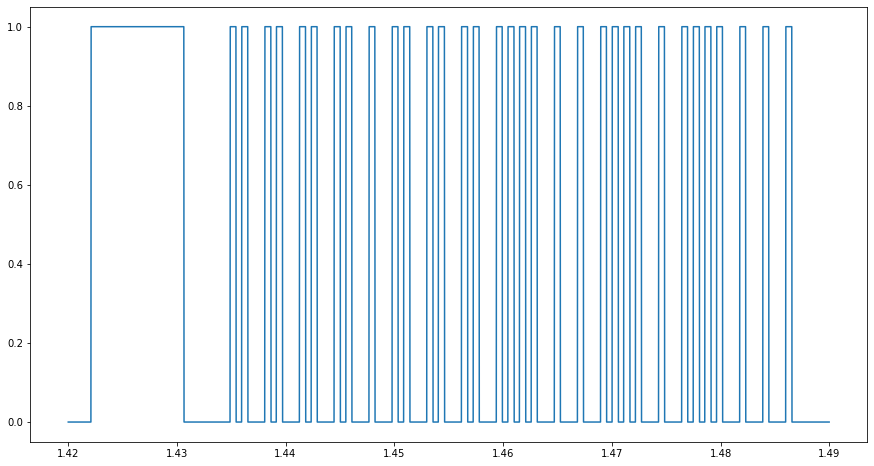

In [20]:
beg = 1.42*samplerate
end = 1.49*samplerate
view = df[(df['sample'] < end) & (df['sample'] > beg)]
plt.figure(figsize=(15,8))
plt.plot(view.time, view.threshed)

Play the audio below through the IR blaster to replay the signal.

In [18]:
df = signal_to_ir(df)
Audio(data=(df['ir_l'], df['ir_r']), rate=samplerate)